In [4]:
import sys
sys.path.append('..')
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta

from tqdm import tqdm
from sqlalchemy import func
import webbrowser
import seaborn as sns
from matplotlib import ticker
from wordcloud import WordCloud
from collections import Counter
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap

from src.pingers import *
from src.models import *
from src import crud
from src.utils import *
from src.models.enums import CreativeType, TextType
from src.fb_api.get_preview_shareable_link import get_preview_shareable_link
from src.statistical_tests import mean_test
from src.crud.utils.get_performance import performance_columns


from src.database.session import db
metrics = (cr, ctr, cpm, roas)
df_path = f'{os.getenv("PATH")}/data/black_friday_{date.today()}.csv'
link_df_path = '{os.getenv("PATH")}/data/top_candiates.csv'

end_date = date.today()
start_date = date(year=2023, month=11, day=1)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
performance_columns

['spend_USD', 'purch_value_USD', 'purch', 'clicks', 'impr']

In [2]:
def get_discounts(text: str) -> list:
    discounts = []
    discounts.extend([match.group() for match in re.finditer(r"(?i)discount\s(of\s)?[\d]+\s?%", text)])
    discounts.extend(re.findall(r"(?i)save\s[\d]+\s?%", text))
    discounts.extend(re.findall(r"(?i)[\d]+\s?%\s?off", text))
    discounts.extend(re.findall(r"(?i)[\d]+\s?%\sdiscount", text))
    discounts.extend(re.findall(r"(?i)-[\d]+\s?%", text))
    discount_values = [int(re.findall(r"\d+", discount)[0]) for discount in discounts]
    return discount_values

In [5]:
force_from_scratch = False
if not os.path.exists(df_path) or force_from_scratch:
    print('Tu sam')
    query = db.query(FacebookDailyPerformance.ad_id).filter(
        FacebookDailyPerformance.date_start.between(start_date, end_date),
    ).group_by(FacebookDailyPerformance.ad_id).having(func.sum(FacebookDailyPerformance.spend) > 500)
    ad_ids_df = read_query_into_df(db=db, query=query, chunk_size=10000)
    ad_ids = ad_ids_df.ad_id.tolist()
    df = ping_facebook_creative_and_performance(
        db=db, ad_id=ad_ids, start_date=start_date, end_date=end_date, period=Period.date
    )

    for metric in metrics:
        df[str(metric)] = df.apply(metric.formula_series, axis=1)

    access_tokens_dict = {
        shop_id: access_token
        for shop_id in df.shop_id.unique().tolist()
        if (access_token := crud.credentials.get_facebook_access_token_by_shop(db=db, shop_id=shop_id))
        is not None
    }
    df.to_csv(df_path, index=False)
df = read_csv_and_eval(df_path)

# filter US ads
df = df[df.countries.apply(lambda l: len(l)) == 1]
df = df[df.countries.apply(lambda l: l[0]) == 'US']

#broken conversion
df = df[df.CR.apply(lambda x: x in cr.interval) & df.CTR.apply(lambda x: x in ctr.interval)]
df = df[df.ROAS.between(100, 7000)]
df = df[df.creative_type != CreativeType.unknown]
# df = df.fillna(value={'discount_value': 0},)
df['count'] = 1
df.date = df.date.apply(lambda date_str: datetime.strptime(date_str, '%Y-%m-%d').date())

Tu sam


OSError: Cannot save file into a non-existent directory: '/app/data'

In [ ]:
column = 'spend_USD'
discounts_by_date = df.groupby([df.date, df.discount_value]).apply(lambda df: df[column].sum())

In [10]:
df.spend_USD.sum()

4371229.423514163

In [ ]:
for text_type in TextType:
    df[f"{text_type}_discounts"] = df[f"{text_type}"].apply(
        lambda texts: sum([get_discounts(text) for text in texts], [])
    )
df["discount_value"] = df.apply(
    lambda row: sum([row[f"{text_type}_discounts"] for text_type in TextType], []), axis=1
)
df.discount_value = df.discount_value.apply(lambda x: [0] if not len(x) else x)
exploded_df = df.copy()
exploded_df[performance_columns] = exploded_df[performance_columns].div(
    exploded_df['discount_value'].apply(len), axis=0
)
exploded_df = exploded_df.explode('discount_value').dropna(axis=0, subset='discount_value')
exploded_df.spend_USD.sum()

4371229.423514163

In [ ]:
df = exploded_df

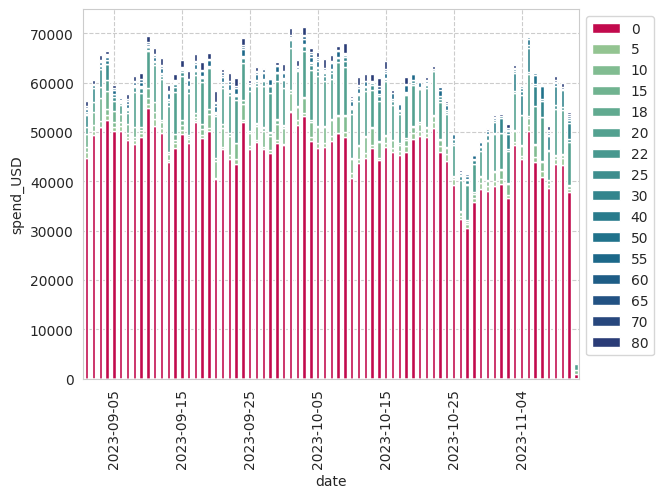

In [ ]:
red_rgb = (0.761, 0.039, 0.3)
column = 'spend_USD'
discounts_by_date = df.groupby([df.date, df.discount_value]).apply(lambda df: df[column].sum())
n_unique_discounts = discounts_by_date.index.get_level_values("discount_value").nunique() - 1
color_palette = sns.color_palette(
    [red_rgb]
    + sns.color_palette(
        "crest", n_colors=n_unique_discounts
    ),
    as_cmap=True,
)
unstacked_df = discounts_by_date.unstack(level='discount_value')
ax = unstacked_df.plot(kind='bar', stacked=True, colormap=ListedColormap(color_palette))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel(column)
plt.show()

In [19]:
month = 11
month_df = df[(date(year=2023, month=month, day=1) <= df.date) & (df.date < date(year=2023, month=month+1, day=1))]
month_df.discount.sum() / len(month_df)

0.3866213151927438

In [22]:
month_df.loc[month_df.discount_value > 0, 'discount_value'].value_counts()

discount_value
20    762
30    224
15    113
25     96
10     36
50     33
5      33
80     29
40     13
65     10
55      7
70      4
60      4
Name: count, dtype: int64

In [29]:
oho = month_df.groupby(month_df.discount_value)['spend_USD'].sum().apply(big_number_human_format).reset_index()
oho.to_csv('/app/data/discount_distribution.csv', index=False)
oho

,discount_value,spend_USD
0,0,467.04K
1,5,10.41K
2,10,16.86K
3,15,2.39K
4,20,86.55K
5,25,3.56K
6,30,39.32K
7,40,4.58K
8,50,6.75K
9,55,2.67K


: 

In [61]:
tmp_df = pd.DataFrame(
    data=[["e1", "f1"], ["e2", "f2"]],
    index=pd.MultiIndex.from_tuples([("a1", "b1", "c1"), ("a2", "b2", "c2")], names=['a', 'b', 'c']),
    columns=['e', 'f']
)
tmp_df.unstack('c')

e         f     
c       c1   c2   c1   c2
a  b                     
a1 b1   e1  NaN   f1  NaN
a2 b2  NaN   e2  NaN   f2

In [46]:
tmp_df = pd.DataFrame(data=[0, 1, 2], index=[2, 3, 3])
tmp_df.unstack().index

MultiIndex([(0, 2),
            (0, 3),
            (0, 3)],
           )

In [41]:
tmp_df

,0
2,0
3,1


<Axes: >

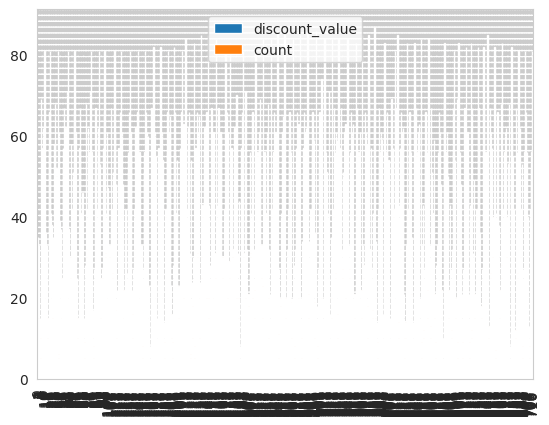

In [17]:
discounts_by_date.plot(kind='bar', stacked=True)

In [14]:
df.ROAS

0       118.282070
1       123.239780
2       545.778512
3       267.246683
4       106.053282
           ...    
1893    107.881914
1894    302.670720
1895    197.988818
1896    384.706694
1897    172.448150
Name: ROAS, Length: 1898, dtype: float64

In [5]:
df.groupby('creative_type').apply(lambda df: df.shop_id.nunique())

creative_type
carousel    56
dynamic     68
image       28
video       27
dtype: int64

In [6]:
df.creative_type.value_counts()

creative_type
dynamic     385
carousel    236
image       109
video        97
Name: count, dtype: int64

In [7]:
df.shop_id.nunique()

104

In [12]:
len(df)

1898

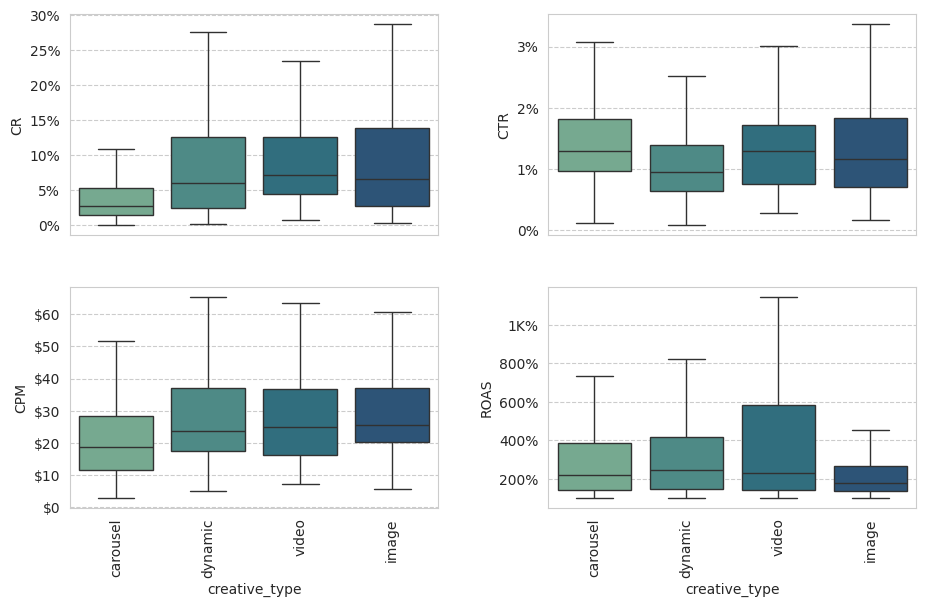

In [9]:
plot_df = df

fig, axs = plt.subplots(2, 2, sharex=True)
fig.tight_layout(pad=2.0)
fig.set_figwidth(10)
fig.set_figheight(6)
for idx, metric in enumerate(metrics):
    ax = axs[idx//2, idx%2]
    g = sns.boxplot(data=df, x='creative_type', hue='creative_type', y=str(metric), palette='crest', showfliers=False, ax=ax)
    g.yaxis.set_major_formatter(ticker.FuncFormatter(metric.format_ticker))
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
plt.show()

In [10]:
creative_types = [ct for ct in get_enum_values(CreativeType) if ct not in (CreativeType.unknown, CreativeType.image)]
grouped_df = df.groupby('creative_type')
sample_dict = {ct: grouped_df.get_group(ct)['ROAS'].to_list() for ct in creative_types}

In [11]:
mean_test(samples_dict=sample_dict)

{'stat': 1.822952597191943,
 'p': 0.4019304165133031,
 'test_type': 'kruskal',
 'stat_levene': 0.542599984593804,
 'p_levene': 0.5814742256595419,
 'video': {'mean': 399.70656570842254, 'size': 97},
 'dynamic': {'mean': 371.36442063525726, 'size': 385},
 'carousel': {'mean': 348.83248988130487, 'size': 236}}

In [12]:
mean_test()

TypeError: mean_test() missing 1 required positional argument: 'samples_dict'

In [13]:
big_number_human_format(num=5_000_000, big_decimals=0)

'5M'

In [14]:
top_candidates = df[(df.days_active > 5) & (df.spend_USD > 800) & (df.creative_type != CreativeType.unknown)]
top_candidates = (
    top_candidates.groupby(['shop_id', "creative_type"]).apply(lambda df: df.nlargest(1, "ROAS")).reset_index(drop=True)
).groupby(['creative_type']).apply(lambda df: df.nlargest(6, "ROAS")).reset_index(drop=True)

In [15]:
top_candidates.shop_id.nunique()

19

In [16]:
# adding links
top_candidates = top_candidates[top_candidates.shop_id.isin(access_tokens_dict.keys())]
top_candidates["preview_link"] = top_candidates.apply(
    lambda row: get_preview_shareable_link(ad_id=row.ad_id, access_token=access_tokens_dict[row.shop_id]), axis=1
)
top_candidates.to_csv('/app/data/top_candiates.csv', index=False)
# for link in top_candidates.preview_link:
#     if link is not None and len(link):
#         webbrowser.open(link)

NameError: name 'access_tokens_dict' is not defined

In [21]:
top_discount_candidates = df[(df.days_active > 5) & (df.spend_USD > 800) & (df.creative_type != CreativeType.unknown) & (df.discount)]

In [22]:
hmm = top_discount_candidates.nlargest(50, 'ROAS')
len(hmm[hmm.discount_value <= 50])

44

In [23]:
sns.color_palette('crest')[5]

(0.14573579, 0.29354139, 0.49847009)

/tmp/ipykernel_11997/2002189826.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.boxplot(data=df, x='creative_type', y=str(metric), palette='crest', showfliers=False, ax=axs)


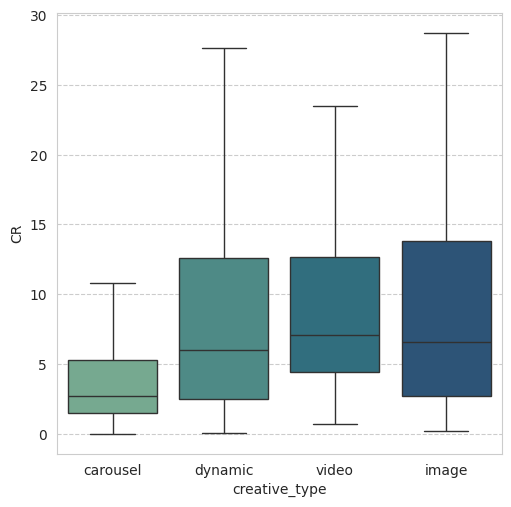

In [24]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
metric = cr
# sns.reset_defaults()
fig, axs = plt.subplots(1, 1, sharex=True)
fig.tight_layout(pad=1.0)
fig.set_figwidth(5)
fig.set_figheight(5)
g = sns.boxplot(data=df, x='creative_type', y=str(metric), palette='crest', showfliers=False, ax=axs)
plt.show()

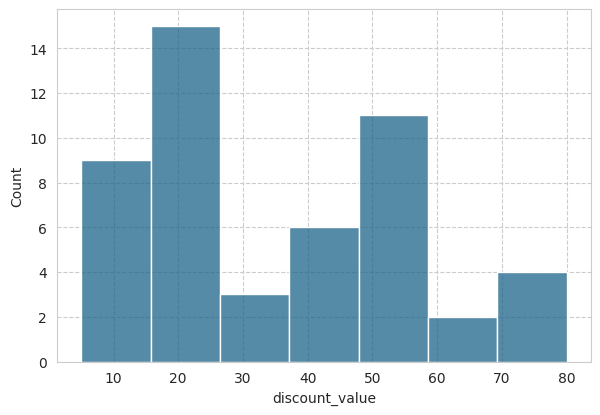

In [25]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
fig, axs = plt.subplots(1, 1, sharex=True)
fig.tight_layout(pad=1.0)
fig.set_figwidth(6)
fig.set_figheight(4)
sns.histplot(data=top_discount_candidates.nlargest(50, 'ROAS'), x='discount_value', color=sns.color_palette('crest')[4], ax=axs)
plt.show()
plt.show()

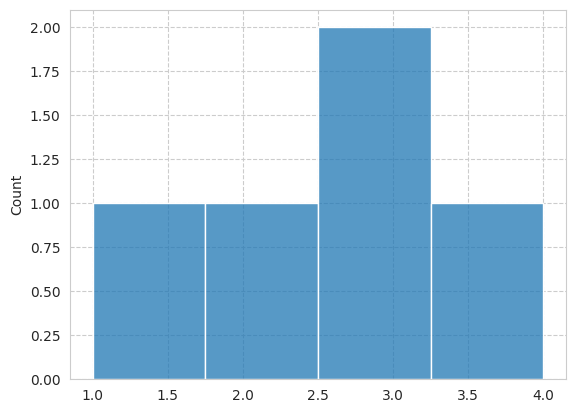

In [26]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(x=[1, 2, 3, 3, 4])
plt.show()

In [27]:
top_candidates

,shop_id,account_id,ad_id,creative_type,title,primary,description,cta,discount,emoji,...,CR,CTR,CPM,ROAS,description_discounts,primary_discounts,title_discounts,discounts,discount_values,discount_value
0,24268796,59007194,6275976606248,carousel,[{{product.name}}],[Still thinking? Here's your 5% OFF discount.\...,[{{product.current_price strip_zeros}}],False,True,False,...,3.919308,1.823130,9.446546,6013.583021,[],[5% OFF],[],[5% OFF],[5],5.0
1,45446054,401446117114204,23848968468360720,carousel,[{{product.name}}],[#1 Mont Alpi Grill Retailer - Free Shipping O...,[],False,False,False,...,0.255646,4.326347,22.259212,3382.248207,[],[],[],[],[],NaN
2,45514705,46057363,6277072116977,carousel,[],[✨ 20% OFF EVERYTHING! ✨ Grab your favorite me...,"[Don't miss this!, Don't miss it!, 20% OFF]",False,True,True,...,30.915371,0.794893,18.739429,1615.812686,[20% OFF],[20% OFF],[],"[20% OFF, 20% OFF]","[20, 20]",20.0
3,45867058,94834424,6299704875375,carousel,[],[],[],False,False,False,...,54.569191,0.794721,23.190505,1160.913369,[],[],[],[],[],NaN
4,101977442,441336120473519,23852306074820767,carousel,[],[NOW OR NEVER: Our Hottest Deals of the Year 🔥...,[Luxury K9 Crystal & Stainless Steel crystal c...,False,True,True,...,0.373134,2.958547,26.596291,960.443711,[],"[50% OFF, 40% OFF, 40% OFF]",[],"[50% OFF, 40% OFF, 40% OFF]","[50, 40, 40]",50.0
5,42535592,613242333127020,23851002390100200,carousel,[],[Custom made shorts / Capris- high waist],[Custom-made shorts that offer control of your...,False,False,False,...,6.519337,1.052118,14.265901,842.996960,[],[],[],[],[],NaN
6,131759935,303750601774224,23852204424710223,dynamic,"[Save USD 408 on Rotimatic+, Biggest Discount ...",[USD 408 OFF on Rotimatic Plus as Black Friday...,[Hurry! Limited Time Offer],False,True,False,...,6.672761,2.583723,38.106294,4948.693785,[],[45% OFF],[],[45% OFF],[45],45.0
7,46167900,452791872345451,23847969539090303,dynamic,[Tumble | Machine Washable & Spillproof Rugs],[Considering a Spillproof & Machine Washable T...,[Rugs Reimagined],False,False,False,...,10.304054,1.452868,28.260731,1644.674957,[],[],[],[],[],NaN
8,45514705,46057363,6276942847977,dynamic,[The best gift for a safer and cozier night’s ...,[✨ 20% OFF EVERYTHING! ✨ Grab your favorite me...,[Don't miss this!],False,True,True,...,40.073529,0.792525,21.782599,1581.887657,[],[20% OFF],[],[20% OFF],[20],20.0
9,128852272,1005922726532575,23852577950010083,dynamic,[Early Black Friday Sale! Save up to $3500 On ...,[Don't wait for spring to arrive before you bu...,[],True,True,True,...,0.128949,2.254393,13.810811,1361.545829,[],"[20% Discount, 20% Discount, 20% Discount]",[],"[20% Discount, 20% Discount, 20% Discount]","[20, 20, 20]",20.0


<Axes: >

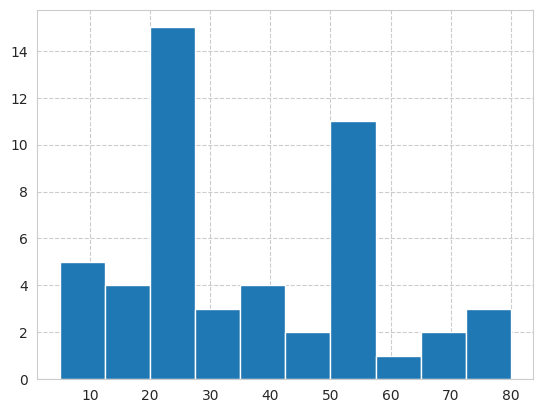

In [28]:
top_discount_candidates.nlargest(50, 'ROAS').discount_value.hist()

In [29]:
top_discount_candidates.creative_type.value_counts() / df.creative_type.value_counts()

creative_type
dynamic     0.220779
carousel    0.194915
image       0.201835
video       0.144330
Name: count, dtype: float64

In [30]:
df.creative_type.value_counts()

creative_type
dynamic     385
carousel    236
image       109
video        97
Name: count, dtype: int64

In [31]:
df.groupby('creative_type').apply(lambda df: df.shop_id.nunique())

creative_type
carousel    56
dynamic     68
image       28
video       27
dtype: int64

In [32]:
link_df = read_csv_and_eval(link_df_path)

In [33]:
creative_type_links_dict = {ct: link_df.loc[link_df.creative_type == ct, 'preview_link'].dropna().tolist() for ct in link_df.creative_type.unique().tolist()}

In [34]:
creative_type_links_dict

{'carousel': ['https://fb.me/1ELl50WuZkRh17v',
  'https://fb.me/1F9zWwVClltpVVl',
  'https://fb.me/22irTsHAZngWvHj',
  'https://fb.me/1MFuMSxMq39RlI2',
  'https://fb.me/1Frdi8tZDr3zOO7'],
 'dynamic': ['https://fb.me/9jDarQxDS3E8pW',
  'https://fb.me/1UrLx4fW3UKV1YP',
  'https://fb.me/1GBkmmFie4IK2b5',
  'https://fb.me/1ZcUcBCIOkTqdUi',
  'https://fb.me/1VVJxIRJqQCJ3Nu'],
 'image': ['https://fb.me/1FRmZrfANkb5yWT',
  'https://fb.me/1NJlwswhVz4Niay',
  'https://fb.me/b0RyExxcDIvVah',
  'https://fb.me/bq8LJLQMoVwSEi'],
 'video': ['https://fb.me/25TrLMIB2ddadly',
  'https://fb.me/1MXqvjk2caFrvNe',
  'https://fb.me/1RdC7nIoRFy0qZb',
  'https://fb.me/1Fhz2iX6dc6vll2',
  'https://fb.me/1R1VPJGoppgSuZa']}

In [35]:
print('\n'.join([ct + '\n' + '\n'.join(creative_type_links_dict[ct]) for ct in creative_type_links_dict.keys()]))

carousel
https://fb.me/1ELl50WuZkRh17v
https://fb.me/1F9zWwVClltpVVl
https://fb.me/22irTsHAZngWvHj
https://fb.me/1MFuMSxMq39RlI2
https://fb.me/1Frdi8tZDr3zOO7
dynamic
https://fb.me/9jDarQxDS3E8pW
https://fb.me/1UrLx4fW3UKV1YP
https://fb.me/1GBkmmFie4IK2b5
https://fb.me/1ZcUcBCIOkTqdUi
https://fb.me/1VVJxIRJqQCJ3Nu
image
https://fb.me/1FRmZrfANkb5yWT
https://fb.me/1NJlwswhVz4Niay
https://fb.me/b0RyExxcDIvVah
https://fb.me/bq8LJLQMoVwSEi
video
https://fb.me/25TrLMIB2ddadly
https://fb.me/1MXqvjk2caFrvNe
https://fb.me/1RdC7nIoRFy0qZb
https://fb.me/1Fhz2iX6dc6vll2
https://fb.me/1R1VPJGoppgSuZa


In [36]:
link_df.shop_id.nunique()

14

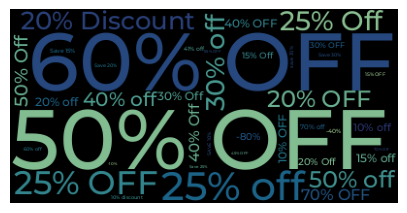

In [48]:
plt.figure(figsize=(5, 5))
discount_text = sum(df[df.discount].discounts.tolist(), [])
wc = WordCloud(
    background_color="black",
    stopwords=set("hey"),
    include_numbers=True,
    font_path=f"{os.getenv('GLOBAL_PATH_TO_REPO')}/data/Montserrat/static/Montserrat-Medium.ttf",
    colormap='crest'
).generate_from_frequencies(frequencies=dict(Counter(discount_text)))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [29]:
discount_text

'25% off, 40% Off, 40% OFF, 40% Off, 40% OFF, -80%, -80%, 10% off, 40% Off, 40% off, 15% off, -80%, 20% off, 20% Off, -80%, 50% OFF, 50% OFF, 50% OFF, 50% OFF, 10% Off, Save 20%, 20% Off, 10% off, 10% off, 10% off, 10% off, 10% off, 30% Off, 40% Off, 40% OFF, 40% Off, 40% OFF, 20% off, 20% off, 20% Off, 20% off, -10%, 10% off, 10% OFF, 20% Off, 20% off, -10%, 15% off, 25% off, 65% Off, 65% OFF, 15% off, 15% off, 30% OFF, 50% Off, 50% Off, 30% Off, 50% OFF, 50% OFF, 50% OFF, 50% OFF, 25% Off, 25% Off, 30% Off, 30% Off, 21% off, 40% OFF, 40% OFF, 50% OFF, 50% OFF, 50% off, 50% OFF, 15% off, 20% off, 20% OFF, 70% off, -80%, -80%, 55% OFF, 55% OFF, -80%, -80%, 20% OFF, 10% OFF, SAVE 10%, 10% OFF, SAVE 10%, -80%, 50% off, 50% OFF, 10% OFF, SAVE 10%, 20% OFF, 40% off, -40%, 40% off, -40%, 40% off, -40%, 40% off, -40%, 30% off, 30% off, 15% off, 50% Off, 30% OFF, 40% Off, 50% OFF, 50% OFF, 30% off, 30% off, 30% Off, 30% off, 30% off, 30% off, 20% Off, 25% off, 25% off, 25% OFF, 50% off, 50% o